In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from torch.nn.utils.rnn import pack_padded_sequence
from torchsummary import summary
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [9]:
TRAIN_PATH = 'new-train-split.csv'
TEST_PATH = 'new-test-split.csv'
VAL_PATH = 'new-dev-split.csv'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NEW_DATA = 'Extra-data.csv'
EMBEDDING_FILE = 'glove.42B.300d.txt'
vocab2index = {"":0, "UNK":1}
MAX_LEN = 2204
PHQ_MAX_VAL = 23
PTSD_MAX_VAL = 85
CHECKPOINT = 'temp_models/'
GRAPHS = 'temp_plots/'

In [10]:
def get_data(dataset):
    """
    Returns features along with normalized PHQ and PTSD values
    :params: dataset - Train/Test/Validation
    """
    features = dataset.Text
    PHQ = dataset.PHQ8_Score
    PHQ = PHQ/PHQ_MAX_VAL
    PTSD = dataset.PTSD
    PTSD = PTSD/PTSD_MAX_VAL
  
    return features, PHQ, PTSD

def get_new_data(dataset):
    """
    Returns features along with normalized PHQ values
    :params: dataset - Train/Test
    """
    features = dataset.Text
    PHQ = dataset.PHQ8_Score
    PHQ = PHQ/PHQ_MAX_VAL
  
    return features, PHQ

In [11]:
def get_embeddings():
    """
    Returns a dictionary containing words as keys and glove word vectors as values
    """
    embeddings_index = {}
    with open(EMBEDDING_FILE, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


In [12]:
def tokenize_text(text):
    """
    Splits text into list of words
    :params: text - input paragraph
    """
    tokens = []
    for txt in text:
        tokens.append(txt.split())
    return tokens

In [13]:
def encode_sentence(text, vocab2index):
    """
    Converts sentences into numerical representation
    :params: text - input paragraph
             vocab2index - dictionary with words as keys and index number as value
    """
    tokenized = tokenize_text([text])
    encoded = np.zeros(MAX_LEN, dtype=np.float32)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized[0]])
    length = min(MAX_LEN, len(enc1))
    encoded[:length] = enc1[:length]
    return  encoded, length

In [14]:
def get_emb_matrix(glove_embed, word_counts, emb_size = 300):
    """
    returns weight matrix for embeddings along with vocabulary and vocab-to-index dictionary
    :params: glove_embed - glove dictionary
             word_counts - unique words in dataset
             emb_size - size of the word embeddings
    """

    vocab_size = len(word_counts) + 2 
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in glove_embed:
            W[i] = glove_embed[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx


In [15]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    
    """
    def __init__(self, patience=8, verbose=False, delta=0, path= 'early_stopping_model.pth'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'early_stopping_vgg16model.pth'   
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model):
        
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0   
    
    def save_checkpoint(self, val_loss, model):
        """
        saves the current best version of the model if there is decrease in validation loss
        """
        torch.save(model.state_dict(), self.path)
        self.vall_loss_min = val_loss

In [27]:
class DepressionDataset(torch.utils.data.Dataset):
    """
    Pytorch implementation of Dataset class to return encoding and their labels
    """
    def __init__(self, encodings, PHQ, PTSD):
        self.encodings = encodings
        self.PHQ = PHQ
        self.PTSD = PTSD

    def __getitem__(self, idx):
        encoding = torch.tensor(self.encodings[idx][0])
        phq_score = torch.tensor(self.PHQ[idx])
        ptsd_score = torch.tensor(self.PTSD[idx])
        length = self.encodings[idx][1]
        
        return encoding, length, phq_score, ptsd_score

    def __len__(self):
        return len(self.PHQ)

class NewDataset(torch.utils.data.Dataset):
    """
    Pytorch implementation of Dataset class to return encoding and their labels
    """
    def __init__(self, encodings, PHQ):
        self.encodings = encodings
        self.PHQ = PHQ

    def __getitem__(self, idx):
        encoding = torch.tensor(self.encodings[idx][0])
        phq_score = torch.tensor(self.PHQ[idx])
        length = self.encodings[idx][1]
        
        return encoding, length, phq_score

    def __len__(self):
        return len(self.PHQ)

In [105]:
class LSTM_Multi_Task(torch.nn.Module) :
    """
    LSTM Multi-task model architecture
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()

        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3, dropout=0.3, bidirectional=True)

        
        self.MLP = nn.Sequential(
            nn.Linear(hidden_dim,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.ptsd_head = nn.Sequential(
            nn.Linear(128,84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(84, 1),
            nn.ReLU()
        )

        self.phq_head = nn.Sequential(
            nn.Linear(128,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 1),
            nn.ReLU()
        )

        
    def forward(self, sentence, sentence_length):
        sentence_embed = self.embeddings(sentence)
        sentence_embed = self.dropout(sentence_embed)

        sentence_pack = pack_padded_sequence(sentence_embed, sentence_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(sentence_pack)
        features = self.MLP(ht[-1])
        ptsd = self.ptsd_head(features)
        phq = self.phq_head(features)

        return torch.squeeze(phq, 1), torch.squeeze(ptsd, 1)


In [106]:
def train(model, optimizer, criterion_phq, criterion_ptsd, train_loader, val_loader, epochs):
    """
    returns trained model along with lossess and accuracies per epoch for multitask architecture
    :params: model - LSTM model
             optimizer - Adam optimizer
             criterion_phq, criterion_ptsd - MSE Loss functions
             train, val loaders - input data and labels
             epochs - number of epochs to train the model
    """
    epoch_train_phq_loss = []
    epoch_train_ptsd_loss = []
    epoch_train_total_loss = []
    epoch_train_ptsd_acc = []

    epoch_val_phq_loss = []
    epoch_val_ptsd_loss = []
    epoch_val_total_loss = []
    epoch_val_ptsd_acc = []

    epoch_val_loss = []
    losses = {'train':{'total':[], 'phq':[], 'ptsd':[]}, 'val':{'total':[], 'phq':[], 'ptsd':[]}}

    print("Training started...\n")
    model.to(DEVICE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.2, last_epoch=-1, verbose=True)
    early_stop = EarlyStopping(patience=8, path= CHECKPOINT+"multitask_early_stopping_bilstm.pth")
    used_early_stopping = False
    
    for epoch in range(epochs):
    
        print("Epoch : ", epoch+1)
        model.train()
        for sentence, length, phq_score, ptsd_score in train_loader:
            sentence = sentence.to(DEVICE).long()
            phq_score = phq_score.to(DEVICE).type(torch.float32)
            ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)

            optimizer.zero_grad()

            phq_op, ptsd_op = model(sentence, length)

            loss_phq = criterion_phq(phq_op, phq_score)
            loss_ptsd = criterion_ptsd(ptsd_op, ptsd_score)
            
            loss = loss_phq + loss_ptsd
            loss.backward()


            epoch_train_phq_loss.append(loss_phq.item())
            epoch_train_ptsd_loss.append(loss_ptsd.item())
            epoch_train_total_loss.append(loss.item())
            optimizer.step()
      
        train_total_loss = np.average(epoch_train_total_loss)
        train_phq_loss = np.average(epoch_train_phq_loss)
        train_ptsd_loss = np.average(epoch_train_ptsd_loss)


        model.eval()
        with torch.no_grad():
            for sentence, length, phq_score, ptsd_score in val_loader:
                sentence = sentence.to(DEVICE).long()
                phq_score = phq_score.to(DEVICE).type(torch.float32)
                ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)

                phq_op, ptsd_op = model(sentence,length)

                loss_phq = criterion_phq(phq_op, phq_score)
                loss_ptsd = criterion_ptsd(ptsd_op, ptsd_score)
                loss = loss_phq + loss_ptsd


                epoch_val_phq_loss.append(loss_phq.item())
                epoch_val_ptsd_loss.append(loss_ptsd.item())
                epoch_val_total_loss.append(loss.item())

      
        val_total_loss = np.average(epoch_val_total_loss)
        val_phq_loss = np.average(epoch_val_phq_loss)
        val_ptsd_loss = np.average(epoch_val_ptsd_loss)


        
        early_stop(val_total_loss, model)
        scheduler.step()
        
        if early_stop.early_stop:
            print("Early stopping")
            used_early_stopping  = True
            break

        print("Train total loss: {0:.3f}, Train PHQ loss: {1:.3f}, Train PTSD loss: {2:.3f} ".format(train_total_loss, train_phq_loss, train_ptsd_loss))
        print("Val total loss: {0:.3f}, Val PHQ loss: {1:.3f}, Val PTSD loss: {2:.3f} ".format(val_total_loss, val_phq_loss, val_ptsd_loss))
        print('----------------------------------------------------------------------------------------------')

        losses['train']['total'].append(train_total_loss) 
        losses['train']['phq'].append(train_phq_loss) 
        losses['train']['ptsd'].append(train_ptsd_loss) 

        losses['val']['total'].append(val_total_loss) 
        losses['val']['phq'].append(val_phq_loss) 
        losses['val']['ptsd'].append(val_ptsd_loss) 

    return model, losses, used_early_stopping

In [17]:
def plot_cm(lab, pred, target_names, title, task, TYPE):
    """
    plots normalized confusion matrix
    :params: lab - actual labels
             pred - predicted labels
             target_names - names of classes
             title - title of plot
             task - name of the task
    """
    cm = confusion_matrix(lab, pred)
    print(cm)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap = "YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    if TYPE == "":
        plt.savefig(GRAPHS+"{}_confusion_matrix.png".format(task))
    else:
        plt.savefig(GRAPHS+"{}_{}_confusion_matrix.png".format(task,TYPE))
    plt.show()
    plt.close()

def draw_training_curves(train_losses, test_losses, curve_name, title, epoch):
    plt.clf()
    
    plt.xlim([0,epoch])
    plt.plot(train_losses, label='Training {}'.format(curve_name))
    plt.plot(test_losses, label='Testing {}'.format(curve_name))
    plt.ylabel(curve_name)
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend(frameon=False)
    plt.savefig(GRAPHS +"{}_curve.png".format(curve_name))
    plt.show()
    plt.close()

In [34]:
#read data from csvs
train_dataset = pd.read_csv(TRAIN_PATH)
test_dataset = pd.read_csv(TEST_PATH)
val_dataset = pd.read_csv(VAL_PATH) 

new_dataset = pd.read_csv(NEW_DATA)

new_dataset = new_dataset.sample(frac=1)

split = int(len(new_dataset)*0.7)
new_train_dataset = new_dataset.iloc[:split,:]
new_test_dataset = new_dataset.iloc[split:,:]

print("New dataset length : ",len(new_dataset))
print("New train length : ",len(new_train_dataset))
print("New test length : ",len(new_test_dataset))

# generate sentences and their labels
# X_train, train_PHQ, train_PTSD = get_data(train_dataset)
# X_val, val_PHQ, val_PTSD = get_data(val_dataset)
# X_test, test_PHQ, test_PTSD = get_data(test_dataset)

new_X_train, new_train_PHQ = get_new_data(new_train_dataset)
new_X_test, new_test_PHQ = get_new_data(new_test_dataset)

new_train_PHQ = new_train_PHQ.values

new_test_PHQ = new_test_PHQ.values


# embeddings_dict = get_embeddings()

# train_text = list(X_train.values)
# val_text = list(X_val.values)
# test_text = list(X_test.values)
# train_tokens = tokenize_text(train_text)
# val_tokens = tokenize_text(val_text)
# test_tokens = tokenize_text(test_text)

new_train_text = list(new_X_train.values)
new_test_text = list(new_X_test.values)


train_tokens = tokenize_text(new_train_text)
test_tokens = tokenize_text(new_test_text)

counts = Counter()
for tok in train_tokens:
    counts.update(tok)
for tok in test_tokens:  
    counts.update(tok)

print("Length of unique words: ", len(counts))

words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

train_encoded = []
val_encoded = []
test_encoded = []

# for text in train_text:
#     train_encoded.append(encode_sentence(text, vocab2index))
# for text in val_text:
#     val_encoded.append(encode_sentence(text, vocab2index))
# for text in test_text:
#     test_encoded.append(encode_sentence(text, vocab2index))

for text in new_train_text:
    train_encoded.append(encode_sentence(text, vocab2index))

for text in new_test_text:
    test_encoded.append(encode_sentence(text, vocab2index))
    
embed_matrix, vocab, vocab_to_idx = get_emb_matrix(embeddings_dict, counts)
print("Shape of Embedding matrix : ", embed_matrix.shape)
print("Shape of Vocabulary : ", vocab.shape)
print("Length of Vocab to index : ", len(vocab_to_idx))

New dataset length :  126
New train length :  88
New test length :  38
Length of unique words:  6174
Shape of Embedding matrix :  (6176, 300)
Shape of Vocabulary :  (6176,)
Length of Vocab to index :  6175


In [122]:
vocab_size = 8360
embedding_dim = 300
hidden_dim = 128
lr = 1e-3
lr_phq = 1e-4
epochs = 500
batch_size = 32

model = LSTM_Multi_Task(vocab_size, embedding_dim, hidden_dim, embed_matrix)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam([{'params':model.lstm.parameters()},
                            {'params':model.MLP.parameters()},
                            {'params':model.ptsd_head.parameters()},
                            {'params':model.phq_head.parameters(), 'lr':lr_phq}], lr=lr
                            )

criterion_phq = torch.nn.MSELoss().to(DEVICE) 
criterion_ptsd = torch.nn.MSELoss().to(DEVICE) 

train_loader = torch.utils.data.DataLoader(DepressionDataset(train_encoded, train_PHQ, train_PTSD), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(DepressionDataset(val_encoded, val_PHQ, val_PTSD), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(DepressionDataset(test_encoded, test_PHQ, test_PTSD), batch_size=batch_size, shuffle=True)

full_train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([DepressionDataset(train_encoded, train_PHQ, train_PTSD),DepressionDataset(val_encoded, val_PHQ, val_PTSD)]), batch_size=batch_size, shuffle=True)

model, losses, early_stop = train(model, optimizer, criterion_phq, criterion_ptsd, full_train_loader, test_loader, epochs)

if early_stop:
    torch.save(model.state_dict(),CHECKPOINT+'multitask_bilstm.pth')

Training started...

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting learning rate of group 2 to 1.0000e-03.
Adjusting learning rate of group 3 to 1.0000e-04.
Epoch :  1
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting learning rate of group 2 to 1.0000e-03.
Adjusting learning rate of group 3 to 1.0000e-04.
Train total loss: 0.318, Train PHQ loss: 0.161, Train PTSD loss: 0.157 
Val total loss: 0.323, Val PHQ loss: 0.155, Val PTSD loss: 0.168 
----------------------------------------------------------------------------------------------
Epoch :  2
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting learning rate of group 2 to 1.0000e-03.
Adjusting learning rate of group 3 to 1.0000e-04.
Train total loss: 0.298, Train PHQ loss: 0.146, Train PTSD loss: 0.152 
Val total loss: 0.319, Val PHQ loss: 0.163, Val PTSD

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting learning rate of group 2 to 1.0000e-03.
Adjusting learning rate of group 3 to 1.0000e-04.
Train total loss: 0.244, Train PHQ loss: 0.133, Train PTSD loss: 0.111 
Val total loss: 0.232, Val PHQ loss: 0.154, Val PTSD loss: 0.079 
----------------------------------------------------------------------------------------------
Epoch :  20
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting learning rate of group 2 to 1.0000e-03.
Adjusting learning rate of group 3 to 1.0000e-04.
Train total loss: 0.242, Train PHQ loss: 0.132, Train PTSD loss: 0.110 
Val total loss: 0.230, Val PHQ loss: 0.152, Val PTSD loss: 0.077 
----------------------------------------------------------------------------------------------
Epoch :  21
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting 

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting learning rate of group 2 to 1.0000e-03.
Adjusting learning rate of group 3 to 1.0000e-04.
Train total loss: 0.200, Train PHQ loss: 0.116, Train PTSD loss: 0.084 
Val total loss: 0.196, Val PHQ loss: 0.133, Val PTSD loss: 0.063 
----------------------------------------------------------------------------------------------
Epoch :  39
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 1 to 1.0000e-03.
Adjusting learning rate of group 2 to 1.0000e-03.
Adjusting learning rate of group 3 to 1.0000e-04.
Train total loss: 0.198, Train PHQ loss: 0.115, Train PTSD loss: 0.083 
Val total loss: 0.194, Val PHQ loss: 0.132, Val PTSD loss: 0.062 
----------------------------------------------------------------------------------------------
Epoch :  40
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 1 to 2.0000e-04.
Adjusting 

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 1 to 2.0000e-04.
Adjusting learning rate of group 2 to 2.0000e-04.
Adjusting learning rate of group 3 to 2.0000e-05.
Train total loss: 0.174, Train PHQ loss: 0.105, Train PTSD loss: 0.069 
Val total loss: 0.179, Val PHQ loss: 0.123, Val PTSD loss: 0.056 
----------------------------------------------------------------------------------------------
Epoch :  58
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 1 to 2.0000e-04.
Adjusting learning rate of group 2 to 2.0000e-04.
Adjusting learning rate of group 3 to 2.0000e-05.
Train total loss: 0.173, Train PHQ loss: 0.105, Train PTSD loss: 0.068 
Val total loss: 0.179, Val PHQ loss: 0.123, Val PTSD loss: 0.056 
----------------------------------------------------------------------------------------------
Epoch :  59
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 1 to 2.0000e-04.
Adjusting 

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 1 to 2.0000e-04.
Adjusting learning rate of group 2 to 2.0000e-04.
Adjusting learning rate of group 3 to 2.0000e-05.
Train total loss: 0.156, Train PHQ loss: 0.096, Train PTSD loss: 0.059 
Val total loss: 0.171, Val PHQ loss: 0.119, Val PTSD loss: 0.052 
----------------------------------------------------------------------------------------------
Epoch :  77
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 1 to 2.0000e-04.
Adjusting learning rate of group 2 to 2.0000e-04.
Adjusting learning rate of group 3 to 2.0000e-05.
Train total loss: 0.155, Train PHQ loss: 0.096, Train PTSD loss: 0.059 
Val total loss: 0.170, Val PHQ loss: 0.118, Val PTSD loss: 0.052 
----------------------------------------------------------------------------------------------
Epoch :  78
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 1 to 2.0000e-04.
Adjusting 

Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 1 to 4.0000e-05.
Adjusting learning rate of group 2 to 4.0000e-05.
Adjusting learning rate of group 3 to 4.0000e-06.
Train total loss: 0.144, Train PHQ loss: 0.091, Train PTSD loss: 0.054 
Val total loss: 0.167, Val PHQ loss: 0.116, Val PTSD loss: 0.051 
----------------------------------------------------------------------------------------------
Epoch :  96
Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 1 to 4.0000e-05.
Adjusting learning rate of group 2 to 4.0000e-05.
Adjusting learning rate of group 3 to 4.0000e-06.
Train total loss: 0.144, Train PHQ loss: 0.090, Train PTSD loss: 0.053 
Val total loss: 0.167, Val PHQ loss: 0.116, Val PTSD loss: 0.051 
----------------------------------------------------------------------------------------------
Epoch :  97
Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 1 to 4.0000e-05.
Adjusting 

Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 1 to 4.0000e-05.
Adjusting learning rate of group 2 to 4.0000e-05.
Adjusting learning rate of group 3 to 4.0000e-06.
Train total loss: 0.136, Train PHQ loss: 0.087, Train PTSD loss: 0.050 
Val total loss: 0.164, Val PHQ loss: 0.114, Val PTSD loss: 0.050 
----------------------------------------------------------------------------------------------
Epoch :  115
Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 1 to 4.0000e-05.
Adjusting learning rate of group 2 to 4.0000e-05.
Adjusting learning rate of group 3 to 4.0000e-06.
Train total loss: 0.136, Train PHQ loss: 0.086, Train PTSD loss: 0.049 
Val total loss: 0.164, Val PHQ loss: 0.114, Val PTSD loss: 0.050 
----------------------------------------------------------------------------------------------
Epoch :  116
Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 1 to 4.0000e-05.
Adjustin

Adjusting learning rate of group 0 to 8.0000e-06.
Adjusting learning rate of group 1 to 8.0000e-06.
Adjusting learning rate of group 2 to 8.0000e-06.
Adjusting learning rate of group 3 to 8.0000e-07.
Train total loss: 0.130, Train PHQ loss: 0.083, Train PTSD loss: 0.047 
Val total loss: 0.161, Val PHQ loss: 0.112, Val PTSD loss: 0.049 
----------------------------------------------------------------------------------------------
Epoch :  134
Adjusting learning rate of group 0 to 8.0000e-06.
Adjusting learning rate of group 1 to 8.0000e-06.
Adjusting learning rate of group 2 to 8.0000e-06.
Adjusting learning rate of group 3 to 8.0000e-07.
Train total loss: 0.129, Train PHQ loss: 0.083, Train PTSD loss: 0.046 
Val total loss: 0.161, Val PHQ loss: 0.112, Val PTSD loss: 0.049 
----------------------------------------------------------------------------------------------
Epoch :  135
Adjusting learning rate of group 0 to 8.0000e-06.
Adjusting learning rate of group 1 to 8.0000e-06.
Adjustin

Adjusting learning rate of group 0 to 8.0000e-06.
Adjusting learning rate of group 1 to 8.0000e-06.
Adjusting learning rate of group 2 to 8.0000e-06.
Adjusting learning rate of group 3 to 8.0000e-07.
Train total loss: 0.125, Train PHQ loss: 0.081, Train PTSD loss: 0.044 
Val total loss: 0.159, Val PHQ loss: 0.111, Val PTSD loss: 0.048 
----------------------------------------------------------------------------------------------
Epoch :  153
Adjusting learning rate of group 0 to 8.0000e-06.
Adjusting learning rate of group 1 to 8.0000e-06.
Adjusting learning rate of group 2 to 8.0000e-06.
Adjusting learning rate of group 3 to 8.0000e-07.
Train total loss: 0.125, Train PHQ loss: 0.081, Train PTSD loss: 0.044 
Val total loss: 0.159, Val PHQ loss: 0.111, Val PTSD loss: 0.048 
----------------------------------------------------------------------------------------------
Epoch :  154
Adjusting learning rate of group 0 to 8.0000e-06.
Adjusting learning rate of group 1 to 8.0000e-06.
Adjustin

Adjusting learning rate of group 0 to 1.6000e-06.
Adjusting learning rate of group 1 to 1.6000e-06.
Adjusting learning rate of group 2 to 1.6000e-06.
Adjusting learning rate of group 3 to 1.6000e-07.
Train total loss: 0.121, Train PHQ loss: 0.079, Train PTSD loss: 0.043 
Val total loss: 0.158, Val PHQ loss: 0.110, Val PTSD loss: 0.048 
----------------------------------------------------------------------------------------------
Epoch :  172
Adjusting learning rate of group 0 to 1.6000e-06.
Adjusting learning rate of group 1 to 1.6000e-06.
Adjusting learning rate of group 2 to 1.6000e-06.
Adjusting learning rate of group 3 to 1.6000e-07.
Train total loss: 0.121, Train PHQ loss: 0.079, Train PTSD loss: 0.042 
Val total loss: 0.158, Val PHQ loss: 0.110, Val PTSD loss: 0.048 
----------------------------------------------------------------------------------------------
Epoch :  173
Adjusting learning rate of group 0 to 1.6000e-06.
Adjusting learning rate of group 1 to 1.6000e-06.
Adjustin

Adjusting learning rate of group 0 to 1.6000e-06.
Adjusting learning rate of group 1 to 1.6000e-06.
Adjusting learning rate of group 2 to 1.6000e-06.
Adjusting learning rate of group 3 to 1.6000e-07.
Train total loss: 0.118, Train PHQ loss: 0.077, Train PTSD loss: 0.041 
Val total loss: 0.157, Val PHQ loss: 0.110, Val PTSD loss: 0.047 
----------------------------------------------------------------------------------------------
Epoch :  191
Adjusting learning rate of group 0 to 1.6000e-06.
Adjusting learning rate of group 1 to 1.6000e-06.
Adjusting learning rate of group 2 to 1.6000e-06.
Adjusting learning rate of group 3 to 1.6000e-07.
Train total loss: 0.118, Train PHQ loss: 0.077, Train PTSD loss: 0.041 
Val total loss: 0.157, Val PHQ loss: 0.110, Val PTSD loss: 0.047 
----------------------------------------------------------------------------------------------
Epoch :  192
Adjusting learning rate of group 0 to 1.6000e-06.
Adjusting learning rate of group 1 to 1.6000e-06.
Adjustin

Adjusting learning rate of group 0 to 3.2000e-07.
Adjusting learning rate of group 1 to 3.2000e-07.
Adjusting learning rate of group 2 to 3.2000e-07.
Adjusting learning rate of group 3 to 3.2000e-08.
Train total loss: 0.116, Train PHQ loss: 0.076, Train PTSD loss: 0.040 
Val total loss: 0.156, Val PHQ loss: 0.109, Val PTSD loss: 0.047 
----------------------------------------------------------------------------------------------
Epoch :  210
Adjusting learning rate of group 0 to 3.2000e-07.
Adjusting learning rate of group 1 to 3.2000e-07.
Adjusting learning rate of group 2 to 3.2000e-07.
Adjusting learning rate of group 3 to 3.2000e-08.
Train total loss: 0.116, Train PHQ loss: 0.076, Train PTSD loss: 0.040 
Val total loss: 0.156, Val PHQ loss: 0.109, Val PTSD loss: 0.047 
----------------------------------------------------------------------------------------------
Epoch :  211
Adjusting learning rate of group 0 to 3.2000e-07.
Adjusting learning rate of group 1 to 3.2000e-07.
Adjustin

Adjusting learning rate of group 0 to 3.2000e-07.
Adjusting learning rate of group 1 to 3.2000e-07.
Adjusting learning rate of group 2 to 3.2000e-07.
Adjusting learning rate of group 3 to 3.2000e-08.
Train total loss: 0.114, Train PHQ loss: 0.075, Train PTSD loss: 0.039 
Val total loss: 0.155, Val PHQ loss: 0.108, Val PTSD loss: 0.047 
----------------------------------------------------------------------------------------------
Epoch :  229
Adjusting learning rate of group 0 to 3.2000e-07.
Adjusting learning rate of group 1 to 3.2000e-07.
Adjusting learning rate of group 2 to 3.2000e-07.
Adjusting learning rate of group 3 to 3.2000e-08.
Early stopping


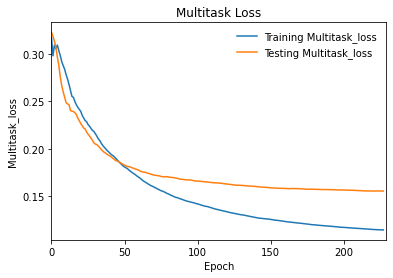

In [123]:
draw_training_curves(losses['train']['total'],losses['val']['total'], 'Multitask_loss', 'Multitask Loss', 229 )

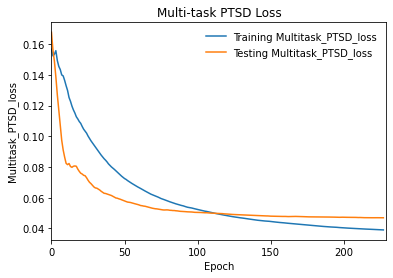

In [124]:
draw_training_curves(losses['train']['ptsd'],losses['val']['ptsd'], 'Multitask_PTSD_loss','Multi-task PTSD Loss', 229 )

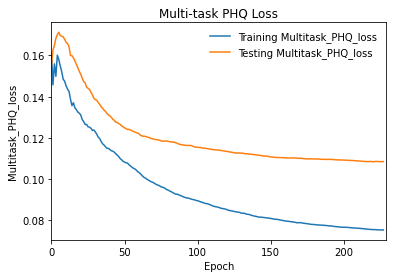

In [125]:
draw_training_curves(losses['train']['phq'],losses['val']['phq'], 'Multitask_PHQ_loss', 'Multi-task PHQ Loss', 229 )

In [126]:
def write_stats(model, filename, epochs):
    f = open(GRAPHS+filename, 'w+')
    f.write('Model Architecture: \n'+str(model))
    f.write('\nEpochs: '+str(epochs))
#     f.write('\nlearning rate: '+str(lr))
    f.write('\nLearning rate PHQ head: '+str(lr_phq))
    f.write('\nLearning rate : '+str(lr))
    f.close()

write_stats(model,"Multitask_details.txt", 500)

In [127]:
torch.save(model.state_dict(),CHECKPOINT+'multitask_bilstm.pth')

In [25]:
class LSTM_Single_Task(torch.nn.Module) :
    """
    LSTM architecture for Single task
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()

        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.4, bidirectional=True)


        self.MLP = nn.Sequential(
            nn.Linear(hidden_dim,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 1),
            nn.ReLU()
        )

    def forward(self, sentence, sentence_length):
        sentence_embed = self.embeddings(sentence)
        sentence_embed = self.dropout(sentence_embed)

        sentence_pack = pack_padded_sequence(sentence_embed, sentence_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(sentence_pack)
        task_op = self.MLP(ht[-1])
        return torch.squeeze(task_op, 1)
# nn.Linear(hidden_dim,64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, 1),
#             nn.ReLU()

In [26]:
def train_single_task(task, model, optimizer, criterion, train_loader, val_loader, epochs):
    """
    returns trained model along with lossess and accuracies per epoch for single task
    :params: model - LSTM model
             optimizer - Adam optimizer
             criterion_phq, criterion_ptsd - MSE Loss functions
             train, val loaders - input data and labels
             epochs - number of epochs to train the model
    """
    epoch_train_loss = []
    epoch_val_loss = []
    losses = {'train':[], 'val':[]}
    used_early_stopping = False
    print("Training started...\n")

    model.to(DEVICE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1, last_epoch=-1, verbose=True)
    early_stop = EarlyStopping(patience=12, path='singletask_{}_early_stopping_model.pth'.format(task))


    for epoch in range(epochs):

        total = 0
        correct =  0
        print("Epoch : ", epoch+1)
        model.train()
        for sentence, length, phq_score, ptsd_score in train_loader:
            sentence = sentence.to(DEVICE).long()
            phq_score = phq_score.to(DEVICE).type(torch.float32)
            ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
            if task == 'PHQ':
                label = phq_score
            else:
                label = ptsd_score

            optimizer.zero_grad()

            task_op = model(sentence, length)

            loss = criterion(task_op, label)
            loss.backward()
            
            epoch_train_loss.append(loss.item())
            optimizer.step()
      
        train_loss = np.average(epoch_train_loss)

        model.eval()
        total = 0
        correct =  0
        with torch.no_grad():
            for sentence, length, phq_score, ptsd_score in val_loader:
                sentence = sentence.to(DEVICE).long()
                phq_score = phq_score.to(DEVICE).type(torch.float32)
                ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
                if task == 'PHQ':
                    label = phq_score
                else: 
                    label = ptsd_score
        
                task_op = model(sentence, length)

                loss = criterion(task_op, label)
        
                epoch_val_loss.append(loss.item())

        val_loss = np.average(epoch_val_loss)

        scheduler.step()
        early_stop(val_loss, model)


        print("Train loss: {0:.3f} Val loss: {1:.3f}".format(train_loss, val_loss))
        print('--------------------------------------------------------------------------------------')

        if early_stop.early_stop:
            print("Early stopping")
            used_early_stopping  = True
            break

        losses['train'].append(train_loss) 
        losses['val'].append(val_loss) 

    return model, losses, used_early_stopping

In [82]:
vocab_size = 8360 #6176
embedding_dim = 300
hidden_dim = 128
lr = 1e-2
epochs = 250
batch_size = 64
task = "PTSD"
model_task = LSTM_Single_Task(vocab_size, embedding_dim, hidden_dim, embed_matrix)
optimizer = torch.optim.Adam(model_task.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(DEVICE) 

train_loader = torch.utils.data.DataLoader(DepressionDataset(train_encoded, train_PHQ, train_PTSD), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(DepressionDataset(val_encoded, val_PHQ, val_PTSD), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(DepressionDataset(test_encoded, test_PHQ, test_PTSD), batch_size=batch_size, shuffle=True)

full_train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([DepressionDataset(train_encoded, train_PHQ, train_PTSD),DepressionDataset(val_encoded, val_PHQ, val_PTSD)]), batch_size=batch_size, shuffle=True)

model_task, losses, early_stop = train_single_task('PTSD', model_task, optimizer, criterion, full_train_loader, test_loader, epochs)


torch.save(model_task.state_dict(), 'singletask_'+task+'_bilstm.pth')

    

Training started...

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch :  1
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.196 Val loss: 0.200
--------------------------------------------------------------------------------------
Epoch :  2
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.183 Val loss: 0.209
--------------------------------------------------------------------------------------
Epoch :  3
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.186 Val loss: 0.212
--------------------------------------------------------------------------------------
Epoch :  4
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.178 Val loss: 0.214
--------------------------------------------------------------------------------------
Epoch :  5
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.177 Val loss: 0.215
--------------------------------------------------------------------------------------
Epoch :  6
Adjustin

Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.071 Val loss: 0.094
--------------------------------------------------------------------------------------
Epoch :  47
Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.070 Val loss: 0.093
--------------------------------------------------------------------------------------
Epoch :  48
Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.070 Val loss: 0.092
--------------------------------------------------------------------------------------
Epoch :  49
Adjusting learning rate of group 0 to 1.0000e-03.
Train loss: 0.069 Val loss: 0.091
--------------------------------------------------------------------------------------
Epoch :  50
Adjusting learning rate of group 0 to 1.0000e-04.
Train loss: 0.068 Val loss: 0.090
--------------------------------------------------------------------------------------
Epoch :  51
Adjusting learning rate of group 0 to 1.0000e-04.
Train loss: 0.067 Val loss: 0.089
-

Adjusting learning rate of group 0 to 1.0000e-05.
Train loss: 0.053 Val loss: 0.069
--------------------------------------------------------------------------------------
Epoch :  92
Adjusting learning rate of group 0 to 1.0000e-05.
Train loss: 0.053 Val loss: 0.068
--------------------------------------------------------------------------------------
Epoch :  93
Adjusting learning rate of group 0 to 1.0000e-05.
Train loss: 0.053 Val loss: 0.068
--------------------------------------------------------------------------------------
Epoch :  94
Adjusting learning rate of group 0 to 1.0000e-05.
Train loss: 0.053 Val loss: 0.068
--------------------------------------------------------------------------------------
Epoch :  95
Adjusting learning rate of group 0 to 1.0000e-05.
Train loss: 0.053 Val loss: 0.068
--------------------------------------------------------------------------------------
Epoch :  96
Adjusting learning rate of group 0 to 1.0000e-05.
Train loss: 0.053 Val loss: 0.067
-

Adjusting learning rate of group 0 to 1.0000e-07.
Train loss: 0.047 Val loss: 0.060
--------------------------------------------------------------------------------------
Epoch :  137
Adjusting learning rate of group 0 to 1.0000e-07.
Train loss: 0.047 Val loss: 0.060
--------------------------------------------------------------------------------------
Epoch :  138
Adjusting learning rate of group 0 to 1.0000e-07.
Train loss: 0.047 Val loss: 0.060
--------------------------------------------------------------------------------------
Epoch :  139
Adjusting learning rate of group 0 to 1.0000e-07.
Train loss: 0.047 Val loss: 0.060
--------------------------------------------------------------------------------------
Epoch :  140
Adjusting learning rate of group 0 to 1.0000e-07.
Train loss: 0.047 Val loss: 0.060
--------------------------------------------------------------------------------------
Epoch :  141
Adjusting learning rate of group 0 to 1.0000e-07.
Train loss: 0.047 Val loss: 0.

Adjusting learning rate of group 0 to 1.0000e-09.
Train loss: 0.045 Val loss: 0.056
--------------------------------------------------------------------------------------
Epoch :  182
Adjusting learning rate of group 0 to 1.0000e-09.
Train loss: 0.044 Val loss: 0.056
--------------------------------------------------------------------------------------
Epoch :  183
Adjusting learning rate of group 0 to 1.0000e-09.
Train loss: 0.044 Val loss: 0.056
--------------------------------------------------------------------------------------
Epoch :  184
Adjusting learning rate of group 0 to 1.0000e-09.
Train loss: 0.044 Val loss: 0.056
--------------------------------------------------------------------------------------
Epoch :  185
Adjusting learning rate of group 0 to 1.0000e-09.
Train loss: 0.044 Val loss: 0.055
--------------------------------------------------------------------------------------
Epoch :  186
Adjusting learning rate of group 0 to 1.0000e-09.
Train loss: 0.044 Val loss: 0.

Adjusting learning rate of group 0 to 1.0000e-11.
Train loss: 0.043 Val loss: 0.053
--------------------------------------------------------------------------------------
Epoch :  227
Adjusting learning rate of group 0 to 1.0000e-11.
Train loss: 0.043 Val loss: 0.053
--------------------------------------------------------------------------------------
Epoch :  228
Adjusting learning rate of group 0 to 1.0000e-11.
Train loss: 0.043 Val loss: 0.053
--------------------------------------------------------------------------------------
Epoch :  229
Adjusting learning rate of group 0 to 1.0000e-11.
Train loss: 0.043 Val loss: 0.053
--------------------------------------------------------------------------------------
Epoch :  230
Adjusting learning rate of group 0 to 1.0000e-11.
Train loss: 0.043 Val loss: 0.053
--------------------------------------------------------------------------------------
Epoch :  231
Adjusting learning rate of group 0 to 1.0000e-11.
Train loss: 0.043 Val loss: 0.

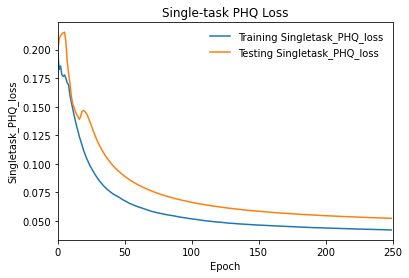

In [83]:

draw_training_curves(losses['train'],losses['val'], 'Singletask_PHQ_loss', 'Single-task PHQ Loss', 250 )

In [78]:
write_stats(model_task,"Singletask_details.txt", 250)

In [86]:
def evaluate_single_task(task, model, criterion, test_loader):
    """
    returns predictions on test dataset with the best trained model for single task
    :params: task - PHQ/PTSD
             model - trained model
             test_loader - test dataset
    """
    output = []
    actual = []
    model.eval()
    loss = []
    with torch.no_grad():
        for sentence, length, phq_score, ptsd_score in test_loader:
            sentence = sentence.to(DEVICE).long()
            phq_score = phq_score.to(DEVICE).type(torch.float32)
            ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
            if task == 'PHQ':
                label = phq_score
            else: 
                label = ptsd_score
            
            ptsdop = model(sentence, length)
            
            loss_val = criterion(ptsdop, label)
            loss.append(loss_val.item())
            output.extend(ptsdop.cpu().tolist())
            actual.extend(label.cpu().tolist())
    
    print("Loss is : ", np.average(loss))
    return actual, output

task = "PTSD"
phq_model  = 'temp_models/singletask_PHQ_early_stopping_model.pth'
ptsd_model = 'temp_models/singletask_PTSD_early_stopping_model.pth'
if task == "PHQ":
    path =  phq_model
else:
    path = ptsd_model
    
loaded_model = LSTM_Single_Task(vocab_size, embedding_dim, hidden_dim, embed_matrix).to(DEVICE)
loaded_model.load_state_dict(torch.load(path))
criterion = torch.nn.MSELoss()
actual, preds = evaluate_single_task(task, loaded_model, criterion, test_loader)


Loss is :  0.04228932037949562


In [87]:
def classify_phq(label, split):
    """
    converts probabilites into classes
    :params: label - class probabilities (actual/predicted)
             split - 2 way split (yes/no) or 3 way split (no/moderate/severe)
    """
    final_label = []
    
    if split == "Three":
        for val in label:
            if val <= 0.434:
                final_label.append("No")
            elif val >0.4340 and val <= 0.608:
                final_label.append("Moderate")
            else:
                final_label.append("Severe")
    else:
        for val in label:
            if val <= 0.434:
                final_label.append("No")
            else:
                final_label.append("Yes")         
    
    return final_label

def classify_ptsd(label):
    """
    converts probabilites into classes
    :params: label - class probabilities (actual/predicted)
    """
    final_label = []
    
    for val in label:
        if val < 0.39:
            final_label.append("No")
        else:
            final_label.append("Yes")
    
    return final_label

            
def print_accuracy(true_label, predicted_label):   
    """
    prints accuracy of the task
    :params: true_label - actual labels of the dataset
             predicted_label - predictions from model
    """
    correct = 0
    total = 0
    for x,y in zip(true_label, predicted_label):
        if x == y:
            correct+=1
        total+=1
        
    print("Accuracy: ", correct/total)
    
    

Accuracy:  0.6170212765957447
[[19  5]
 [13 10]]


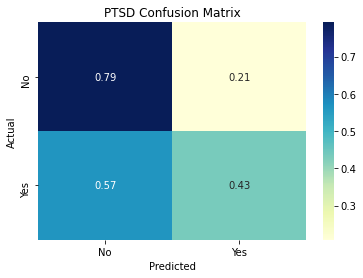

In [88]:
true_label = classify_ptsd(actual)
pred_label = classify_ptsd(preds)

print_accuracy(true_label, pred_label)
plot_cm(true_label, pred_label, ["No", "Yes"], "PTSD Confusion Matrix", "Singletask_"+task, "")


In [70]:

two_true_label = classify_phq(actual, 'Two')
three_true_label = classify_phq(actual, 'Three')

two_pred_label = classify_phq(preds, 'Two')
three_pred_label = classify_phq(preds, 'Three')


Accuracy:  0.7021276595744681
[[29  4]
 [10  4]]


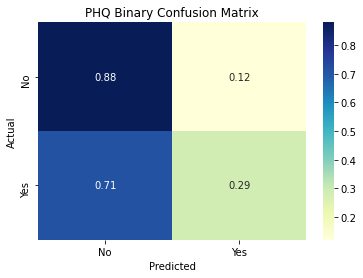

In [71]:
print_accuracy(two_true_label, two_pred_label)
plot_cm(two_true_label, two_pred_label, ["No", "Yes"], "PHQ Binary Confusion Matrix", "Singletask_"+task, "Binary")

Accuracy:  0.6382978723404256
[[ 1  4  0]
 [ 3 29  1]
 [ 3  6  0]]


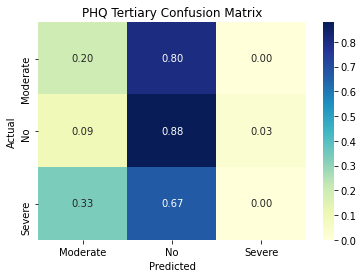

In [72]:
print_accuracy(three_true_label, three_pred_label)
plot_cm(three_true_label, three_pred_label, ["Moderate", "No", "Severe"], "PHQ Tertiary Confusion Matrix", "Singletask_"+task, 'Tertiary')

In [128]:
def evaluate_multi_task(model, test_loader):
    """
    returns predictions on test dataset with the best trained model for single task
    :params: task - PHQ/PTSD
             model - trained model
             test_loader - test dataset
    """
    output_phq = []
    actual_phq = []
    
    output_ptsd = []
    actual_ptsd = []
    
    model.eval()

    with torch.no_grad():
        for sentence, length, phq_score, ptsd_score in test_loader:
            sentence = sentence.to(DEVICE).long()
            phq_score = phq_score.to(DEVICE).type(torch.float32)
            ptsd_score = ptsd_score.to(DEVICE).type(torch.float32)
            
            phqop, ptsdop = model(sentence, length)
            
            
            output_phq.extend(phqop.cpu().tolist())
            actual_phq.extend(phq_score.cpu().tolist())
            
            output_ptsd.extend(ptsdop.cpu().tolist())
            actual_ptsd.extend(ptsd_score.cpu().tolist())
    

    return actual_phq, actual_ptsd, output_phq, output_ptsd


multi_model = 'temp_models/multitask_bilstm.pth'

load_multi_model = LSTM_Multi_Task(vocab_size, embedding_dim, hidden_dim, embed_matrix).to(DEVICE)
load_multi_model.load_state_dict(torch.load(multi_model))

actual_phq, actual_ptsd, output_phq, output_ptsd = evaluate_multi_task(load_multi_model, test_loader)

Counter({'No': 24, 'Yes': 23})
Accuracy:  0.6595744680851063
[[19  5]
 [11 12]]


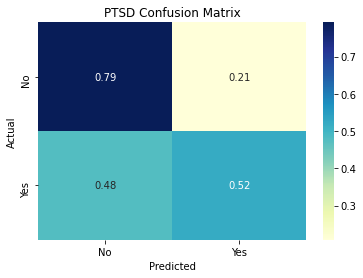

In [129]:
true_label = classify_ptsd(actual_ptsd)
pred_label = classify_ptsd(output_ptsd)

print(Counter(true_label))
print_accuracy(true_label, pred_label)
plot_cm(true_label, pred_label, ["No", "Yes"], "PTSD Confusion Matrix", 'Multitask_PTSD', "")

Accuracy:  0.7659574468085106
[[33  0]
 [11  3]]


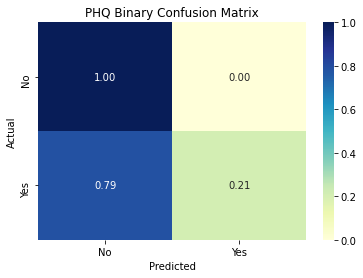

In [130]:
two_true_label = classify_phq(actual_phq, 'Two')
three_true_label = classify_phq(actual_phq, 'Three')

two_pred_label = classify_phq(output_phq, 'Two')
three_pred_label = classify_phq(output_phq, 'Three')

print_accuracy(two_true_label, two_pred_label)
plot_cm(two_true_label, two_pred_label, ["No", "Yes"], "PHQ Binary Confusion Matrix", 'Multitask_PHQ', "Binary")

Accuracy:  0.7021276595744681
[[ 0  4  1]
 [ 0 33  0]
 [ 2  7  0]]


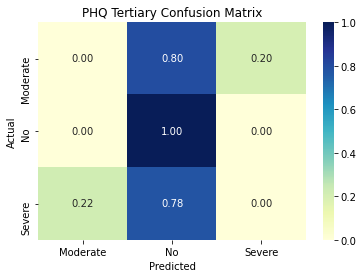

In [131]:
print_accuracy(three_true_label, three_pred_label)
plot_cm(three_true_label, three_pred_label, ["Moderate", "No", "Severe"], "PHQ Tertiary Confusion Matrix", "Multitask_PHQ", 'Tertiary')

In [ ]:
"""
References:
1. https://docs.google.com/document/d/1_PycTNBTQjboYtyZslkte0WlcdyMlyFTMYZlSHLq0EE/edit#
PTSD = 66%
"""

In [36]:
def new_train_single_task(task, model, optimizer, criterion, train_loader, val_loader, epochs):
    """
    returns trained model along with lossess and accuracies per epoch for single task
    :params: model - LSTM model
             optimizer - Adam optimizer
             criterion_phq, criterion_ptsd - MSE Loss functions
             train, val loaders - input data and labels
             epochs - number of epochs to train the model
    """
    epoch_train_loss = []
    epoch_val_loss = []
    losses = {'train':[], 'val':[]}
    used_early_stopping = False
    print("Training started...\n")

    model.to(DEVICE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1, last_epoch=-1, verbose=True)
    early_stop = EarlyStopping(patience=12, path='singletask_{}_early_stopping_model.pth'.format(task))


    for epoch in range(epochs):

        total = 0
        correct =  0
        print("Epoch : ", epoch+1)
        model.train()
        for sentence, length, phq_score in train_loader:
            sentence = sentence.to(DEVICE).long()
            label = phq_score.to(DEVICE).type(torch.float32)
           

            optimizer.zero_grad()

            task_op = model(sentence, length)

            loss = criterion(task_op, label)
            loss.backward()
            
            epoch_train_loss.append(loss.item())
            optimizer.step()
      
        train_loss = np.average(epoch_train_loss)

        model.eval()
        total = 0
        correct =  0
        with torch.no_grad():
            for sentence, length, phq_score in val_loader:
                sentence = sentence.to(DEVICE).long()
                label = phq_score.to(DEVICE).type(torch.float32)
               
        
                task_op = model(sentence, length)

                loss = criterion(task_op, label)
        
                epoch_val_loss.append(loss.item())

        val_loss = np.average(epoch_val_loss)

        scheduler.step()
        early_stop(val_loss, model)


        print("Train loss: {0:.3f} Val loss: {1:.3f}".format(train_loss, val_loss))
        print('--------------------------------------------------------------------------------------')

        if early_stop.early_stop:
            print("Early stopping")
            used_early_stopping  = True
            break

        losses['train'].append(train_loss) 
        losses['val'].append(val_loss) 

    return model, losses, used_early_stopping

In [38]:
vocab_size = 6176
embedding_dim = 300
hidden_dim = 128
lr = 1e-2
epochs = 600
batch_size = 64
task = "PHQ"

model_task = LSTM_Single_Task(vocab_size, embedding_dim, hidden_dim, embed_matrix)
optimizer = torch.optim.Adam(model_task.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(DEVICE) 

train_loader = torch.utils.data.DataLoader(NewDataset(train_encoded, new_train_PHQ), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(NewDataset(test_encoded, new_test_PHQ), batch_size=batch_size, shuffle=True)

model_task, losses, early_stop = new_train_single_task(task, model_task, optimizer, criterion, train_loader, test_loader, epochs)


torch.save(model_task.state_dict(), 'singletask_'+task+'_bilstm.pth')

Training started...

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch :  1
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.126 Val loss: 0.109
--------------------------------------------------------------------------------------
Epoch :  2
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.115 Val loss: 0.084
--------------------------------------------------------------------------------------
Epoch :  3
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.114 Val loss: 0.078
--------------------------------------------------------------------------------------
Epoch :  4
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.116 Val loss: 0.082
--------------------------------------------------------------------------------------
Epoch :  5
Adjusting learning rate of group 0 to 1.0000e-02.
Train loss: 0.117 Val loss: 0.079
--------------------------------------------------------------------------------------
Epoch :  6


KeyboardInterrupt: 